In [1]:
import numpy as np
import tensorflow as tf
from IPython import display
from tqdm import tnrange
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.layers as L
from lfw_dataset import decode_image_from_raw_bytes, load_lfw_dataset

%matplotlib inline

Using TensorFlow backend.


In [2]:
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

In [3]:
def show_sample():
    plt.rcParams["figure.figsize"] = 16, 8
    for i in range(50):
        plt.subplot(5,10, i+1)
        plt.imshow(data[np.random.randint(data.shape[0])])
        plt.axis("off")

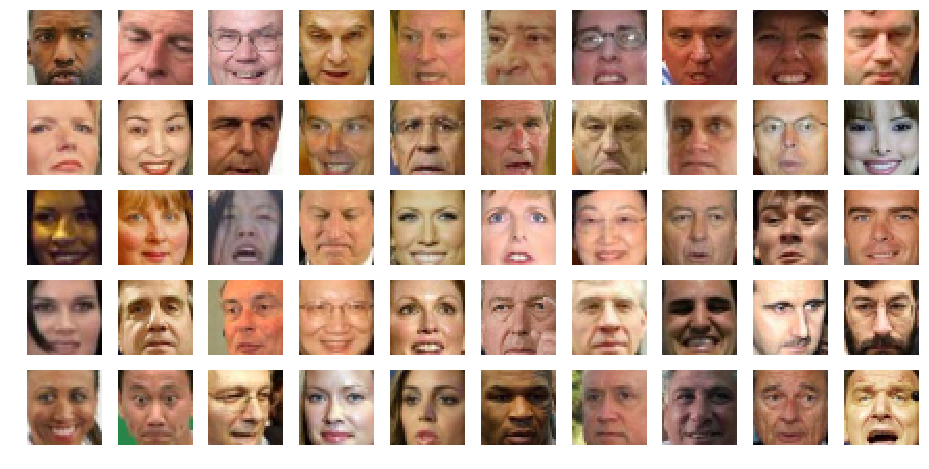

In [4]:
show_sample()

In [5]:
CODE_SIZE = 256
IMG_SHAPE = data.shape[1:]

In [6]:
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.60)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [7]:
def Generator_Model(CODE_SIZE):
    generator = Sequential()
    generator.add(L.InputLayer([CODE_SIZE],name='noise'))
    generator.add(L.Dense(10*8*8, activation='elu'))
    generator.add(L.Reshape((8,8,10)))
    generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
    generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
    generator.add(L.UpSampling2D(size=(2,2)))
    generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
    generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
    generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
    generator.add(L.Conv2D(3,kernel_size=3,activation=None))
    
    return generator

In [8]:
generator = Generator_Model(CODE_SIZE)

In [9]:
generator.summary()
#SVG(model_to_dot(generator).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 640)               164480    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 36, 36, 32)        9248      
__________

In [10]:
def Discriminator_Model(IMG_SHAPE=IMG_SHAPE):
    discriminator = Sequential()
    discriminator.add(L.InputLayer(IMG_SHAPE))
    discriminator.add(L.Conv2D(filters=8, kernel_size=(3, 3)))
    discriminator.add(L.LeakyReLU(0.1))
    discriminator.add(L.Conv2D(filters=16, kernel_size=(3, 3)))
    discriminator.add(L.LeakyReLU(0.1))
    discriminator.add(L.MaxPool2D(pool_size=(2,2), strides=None))
    discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3)))
    discriminator.add(L.LeakyReLU(0.1))
    discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3)))
    discriminator.add(L.LeakyReLU(0.1))
    discriminator.add(L.MaxPool2D(pool_size=(2,2), strides=None))
    discriminator.add(L.Flatten())
    discriminator.add(L.Dense(256,activation='tanh'))
    discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
    
    return discriminator

In [11]:
discriminator = Discriminator_Model()

In [12]:
discriminator.summary()
#SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 34, 34, 8)         224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 34, 34, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
__________

In [13]:
noise = tf.placeholder(dtype="float32", shape=[None, CODE_SIZE])
real_data = tf.placeholder(dtype="float32", shape=[None]+list(IMG_SHAPE))

log_p_real = discriminator(real_data)

generated_data = generator(noise)
log_p_generated = discriminator(generated_data)

In [14]:
# Discriminator Loss
discr_loss = -tf.reduce_mean(log_p_generated[:,0] + log_p_real[:, 1])

# Discrimintor Regularizer
discr_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

# Discrimimator Optimiser
discr_optmzr = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(discr_loss, var_list=discriminator.trainable_weights)

In [15]:
# Generator Loss
gen_loss = -tf.reduce_mean(log_p_generated[:, 1])

# Generator Optimizer
gen_optmzr = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(gen_loss, var_list=generator.trainable_weights)

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
def sample_noise_batch(batch_size):
    return np.random.normal(size=(batch_size, CODE_SIZE)).astype('float32') 

def sample_data_batch(batch_size):
    indices = np.random.choice(a=np.arange(data.shape[0]), size=batch_size)
    return data[indices]    

def sample_images(row, column, sharp=None):
    images = generator.predict(sample_noise_batch(batch_size=row*column))
    if np.var(images) != 0:
        images = images.clip(np.min(data), np.max(data))
    
    for i in range(row*column):
        plt.subplot(row, column, i+1)
        plt.axis("off")
        if sharp is None:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray", interpolation=sharp)
    plt.show()
    

def sample_probability(batch_size):
    plt.title("Generated vs Real Data")
    D_x = np.exp(discriminator.predict(sample_data_batch(batch_size)))[:, 1]
    D_G_x = np.exp(discriminator.predict(generator.predict(sample_noise_batch(batch_size))))[:, 1]                           

    plt.hist(x=D_x, label="D(x)", alpha=0.5, range=[0,1])
    plt.hist(x=D_G_x, label="D(G(x))", alpha=0.5, range=[0,1])

    plt.legend(loc="best")
    plt.show()

In [19]:
TOTAL_EPOCH = 50000
batch_size = 100
graph_batch_size = 1000
GEN_RUN = 5
DISC_RUN = 1
interpolation_methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
                         'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
                         'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

Epoch No: 0


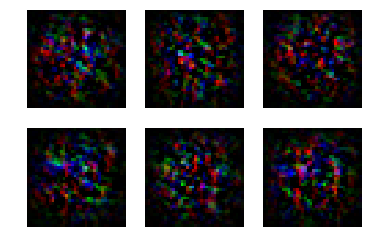

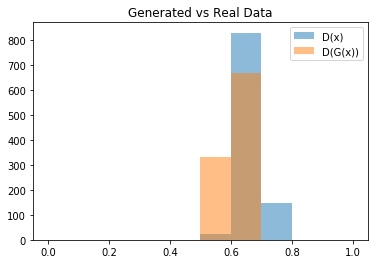

KeyboardInterrupt: 

In [20]:
plt.rcParams["figure.figsize"] = 6,4
for epoch in tnrange(TOTAL_EPOCH):
    
    feed_dict = {
                    real_data:sample_data_batch(100),
                    noise:sample_noise_batch(100)
                }
    
    for i in range(GEN_RUN):
        sess.run(discr_optmzr,feed_dict)
    
    for i in range(DISC_RUN):
        sess.run(gen_optmzr,feed_dict)
    
    
    if epoch %100==0:
        display.clear_output(wait=True)
        print("Epoch No: {}".format(epoch))
        sample_images(2,3,None)
        sample_probability(graph_batch_size)
        